# Diffraction-limited Tiger IFU micropupil, Fresnel edition

*A. Bolton, 2023 Mar*

This notebook implements a Fresnel-mode toy model for the micropupil image
generated by a single square lenslet aperture
of a Tiger-type IFU microlens array in the diffraction limited regime. In this type of IFU,
the micropupil image serves as the spectrograph PSF (after being dispersed and reimaged).
The motivation is (a) to see if the shape of the micropupil image changes
as the telescope focal-plane PSF is shifted across the lenslet and (b) to set up
the Fresnel machinery to do the Bigre IFU simulation next.

**tl;dr: In the diffraction-limited regime (unlike in the seeing-limited regime),
the shape of the spectrograph PSF in a Tiger IFU will depend on the
spatial structure of the sky image illuminating the microlens array.**

Why does this happen?

If $\lambda$ is the wavelength of light, $D$ is the primary mirror diameter,
$f$ is the effective focal length of the telescope beam at the microlens array, and $d$ is the physical
size of the IFU lenslet, then the condition for critical sampling of the telescope PSF (of angular scale $\lambda/D$) by the lenslet (subtending an angle $d/f$) is $ d / f \sim \lambda / D $. At the same time, the condition for the pupil image (subtending an angle $D/f$ at the lenslet) to become unresolved by the lenslet
(with angular diffraction limit $\lambda/d$) is $D / f \sim \lambda/d$. These conditions are mathematically the same: $Dd \sim \lambda f$.

This notebook is an update of the following notebook which used a simpler Fraunhofer model:  
https://github.com/adambolton/optics-notebooks/blob/main/tiger-micropupil-diffraction.ipynb  
The main take-aways are the same, with some differences in the details, and with
the addition of physical units for the scale of the micropupil image.

### Toy model definition

The simple model is a 6.5m circular aperture with a central obscuration and
three supports, focusing onto a small square aperture of size 40 mas that
we will shift around in the focal plane. A lens with the nominal microlens focal length (and coincident with the square aperture) will then form a micropupil image that will be dispersed and reimaged by the spectrograph.
The optics of the spectrograph itself are not modeled here.

The following cells define the model and display the intermediate planes for one setup/wavelength.

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import poppy
from poppy.poppy_core import PlaneType
import astropy.units as u
import astropy.io.fits as fits
import copy

In [2]:
# Model parameters
fl_pri = 3607.5 * u.m  # primary beam focal length (not used in Fraunhofer mode)
diam = 6.5 * u.m       # primary aperture diameter
fs_size = .04          # 40 mas field stop for MLA aperture
fl_mla = 0.0112 * u.m  # focal length of MLA lenslet (not used in Fraunhofer mode)
sec_rad = 0.65*u.m     # secondary radius
n_supp = 3             # number of secondary supports
supp_wid = 0.15*u.m    # width of secondary supports
npix = 1024            # number of pixels across pupil
detscale = 1.*u.micron/u.pixel # pixel scale of "detector" used to capture micropupil image
detfov = 64*u.pixel    # number of pixels across field of view of micropupil "detector"

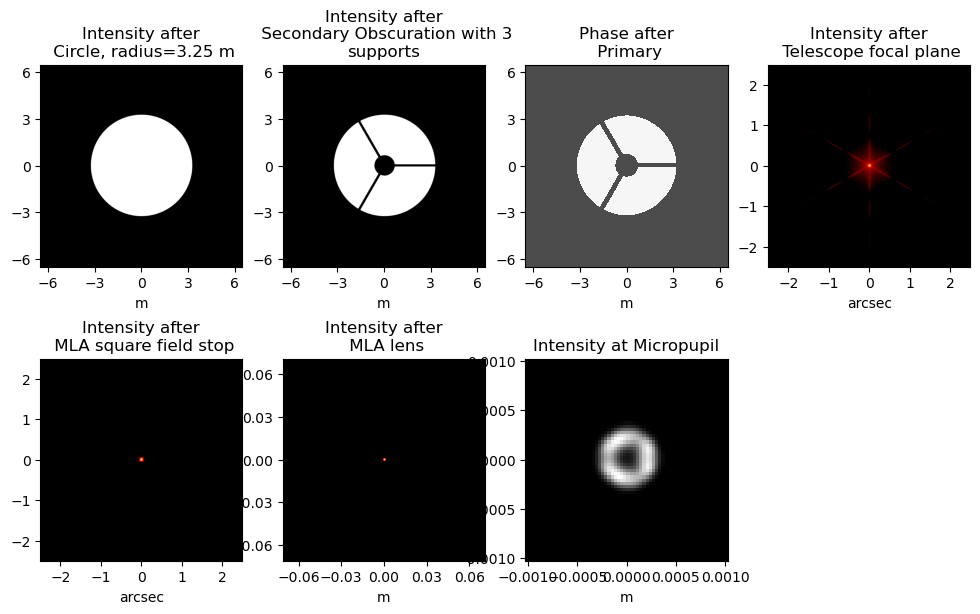

In [3]:
# Display intermediate planes
prim_ap = poppy.CircularAperture(radius=diam/2)
sqstop = poppy.SquareFieldStop(size=2.*fs_size, name='MLA square field stop')
#sqstop.shift_x = 0. * fs_size
toy = poppy.FresnelOpticalSystem(pupil_diameter=2.*diam, npix=npix)
toy.add_optic(prim_ap)
toy.add_optic(poppy.SecondaryObscuration(secondary_radius=sec_rad, n_supports=n_supp, support_width=supp_wid))
toy.add_optic(poppy.QuadraticLens(fl_pri, name='Primary'))
toy.add_optic(poppy.ScalarTransmission(planetype=PlaneType.image, name='Telescope focal plane'), distance=fl_pri)
toy.add_optic(sqstop)
toy.add_optic(poppy.QuadraticLens(fl_mla, name='MLA lens'))
toy.add_detector(pixelscale=detscale, fov_pixels=detfov, distance=fl_mla)
toy.planes[-1].wavefront_display_hint = 'intensity'
toy.planes[-1].name = 'Micropupil'
plt.figure(figsize=(12,7))
psf, waves = toy.calc_psf(wavelength=.5*u.micron, display_intermediates=True, return_intermediates=True)

### Dependence on position of telescope PSF within lenslet

This next section computes the micropupil PSF for three different wavelengths and
four different values of the shift of the telescope PSF within the lenslet.
(Note that shifts are purely in x, and are in units of the spaxel width relative to
zero-shift being centered in the spaxel. So, a 0.5 spaxel shift aligns the telescope PSF
with the edge of the microlens aperture.)

The micropupil shape clearly changes as the telescope PSF moves within the lenslet (although
this is not readily apparent at the longest wavelength.) This implies that the spectrograph line-spread
function and cross-sectional profile will vary according to the spatial illumination pattern
within the lenslet.

In [4]:
wavelengths = [.4 * u.micron, 1.*u.micron, 1.7*u.micron]
shifts = [0., .25, .5, .75]
psf_array = [[None for i in range(len(waves))] for j in range(len(shifts))]

for j_shift, this_shift in enumerate(shifts):
    #print(this_shift, j_shift)
    prim_ap = poppy.CircularAperture(radius=diam/2)
    sqstop = poppy.SquareFieldStop(size=fs_size, name='MLA square field stop')
    toy = poppy.FresnelOpticalSystem(pupil_diameter=2.*diam, npix=npix)
    toy.add_optic(prim_ap)
    toy.add_optic(poppy.SecondaryObscuration(secondary_radius=sec_rad, n_supports=n_supp, support_width=supp_wid))
    toy.add_optic(poppy.QuadraticLens(fl_pri, name='Primary'))
    toy.add_optic(poppy.ScalarTransmission(planetype=PlaneType.image, name='Telescope focal plane'), distance=fl_pri)
    sqstop.shift_x = this_shift * fs_size
    toy.add_optic(sqstop)
    toy.add_optic(poppy.QuadraticLens(fl_mla, name='MLA lens'))
    toy.add_detector(pixelscale=detscale, fov_pixels=detfov, distance=fl_mla)
    for i_wave, this_wave in enumerate(wavelengths):
        psf, waves = toy.calc_psf(wavelength=this_wave, display_intermediates=False, return_intermediates=True)
        psf_array[j_shift][i_wave] = copy.deepcopy(waves[-1].intensity)

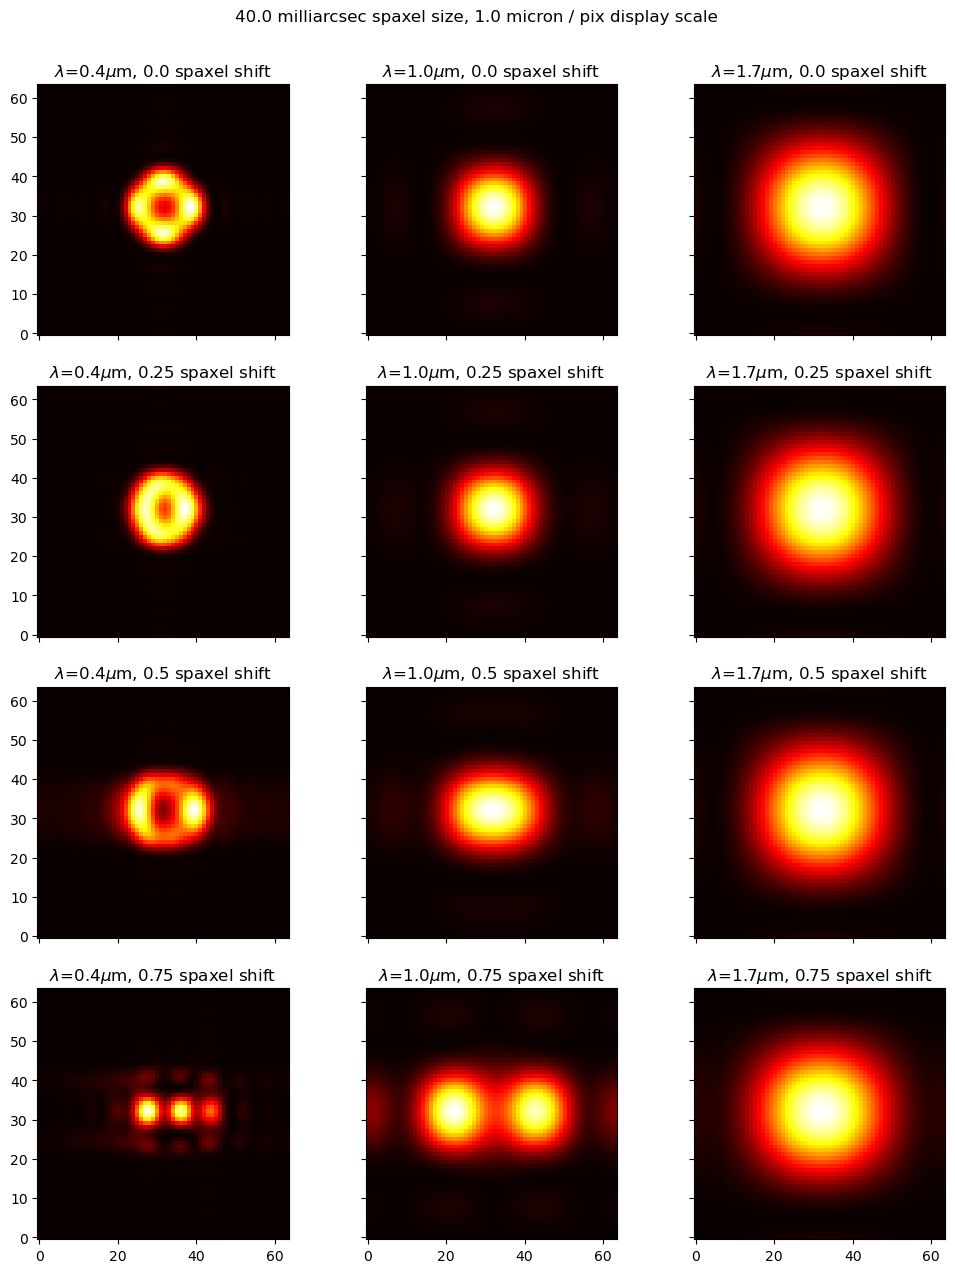

In [5]:
# Make plot
n_w = len(wavelengths)
n_s = len(shifts)
fig, axis = plt.subplots(n_s, n_w, sharex=True, sharey=True)
for i in range(n_w):
    for j in range(n_s):
        axis[j,i].set_box_aspect(1)
        axis[j,i].imshow(psf_array[j][i], cmap='hot', interpolation='none', origin='lower')
        axis[j,i].set_title('$\lambda$='+str(wavelengths[i].value) + '$\mu$m, ' + str(shifts[j])+' spaxel shift')

fig.set_figwidth(12)
fig.set_figheight(15)
junk = fig.suptitle(str(1000 * fs_size) + ' milliarcsec spaxel size, ' + 
                    detscale.to_string() + ' display scale', y=.93)

### Dependence on angular size of spaxel / lenslet

The next section keeps the telescope PSF in the center of the lenslet but increases
the lenslet size by a few multiples, for the same three wavelengths as above.

This illustrates the transition to a more recognizable pupil image as the
lenslet gets bigger.

Note that the reduction from a lenslet size of 700 $\mu$m
to a micropupil size of about 20 $\mu$m is roughly what is predicted based on the
f-ratios of the beam before and after the microlens (f/555 to f/16).

Not sure what is happening with the shortest wavelength for the larger
lenslet apertures. Am thinking this may be related to the combination
of interference and field curvature.

In [6]:
wavelengths = [.4*u.micron, 1.*u.micron, 1.7*u.micron]
scales = [1., 2., 5., 10.]
psf_array = [[None for i in range(len(waves))] for j in range(len(scales))]

for j_scale, this_scale in enumerate(scales):
    prim_ap = poppy.CircularAperture(radius=diam/2)
    sqstop = poppy.SquareFieldStop(size=this_scale*fs_size, name='MLA square field stop')
    toy = poppy.FresnelOpticalSystem(pupil_diameter=2.*diam, npix=npix)
    toy.add_optic(prim_ap)
    toy.add_optic(poppy.SecondaryObscuration(secondary_radius=sec_rad, n_supports=n_supp, support_width=supp_wid))
    toy.add_optic(poppy.QuadraticLens(fl_pri, name='Primary'))
    toy.add_optic(poppy.ScalarTransmission(planetype=PlaneType.image, name='Telescope focal plane'), distance=fl_pri)
    toy.add_optic(sqstop)
    toy.add_optic(poppy.QuadraticLens(fl_mla, name='MLA lens'))
    toy.add_detector(pixelscale=detscale, fov_pixels=detfov, distance=fl_mla)
    for i_wave, this_wave in enumerate(wavelengths):
        psf, waves = toy.calc_psf(wavelength=this_wave, display_intermediates=False, return_intermediates=True)
        psf_array[j_scale][i_wave] = copy.deepcopy(waves[-1].intensity)

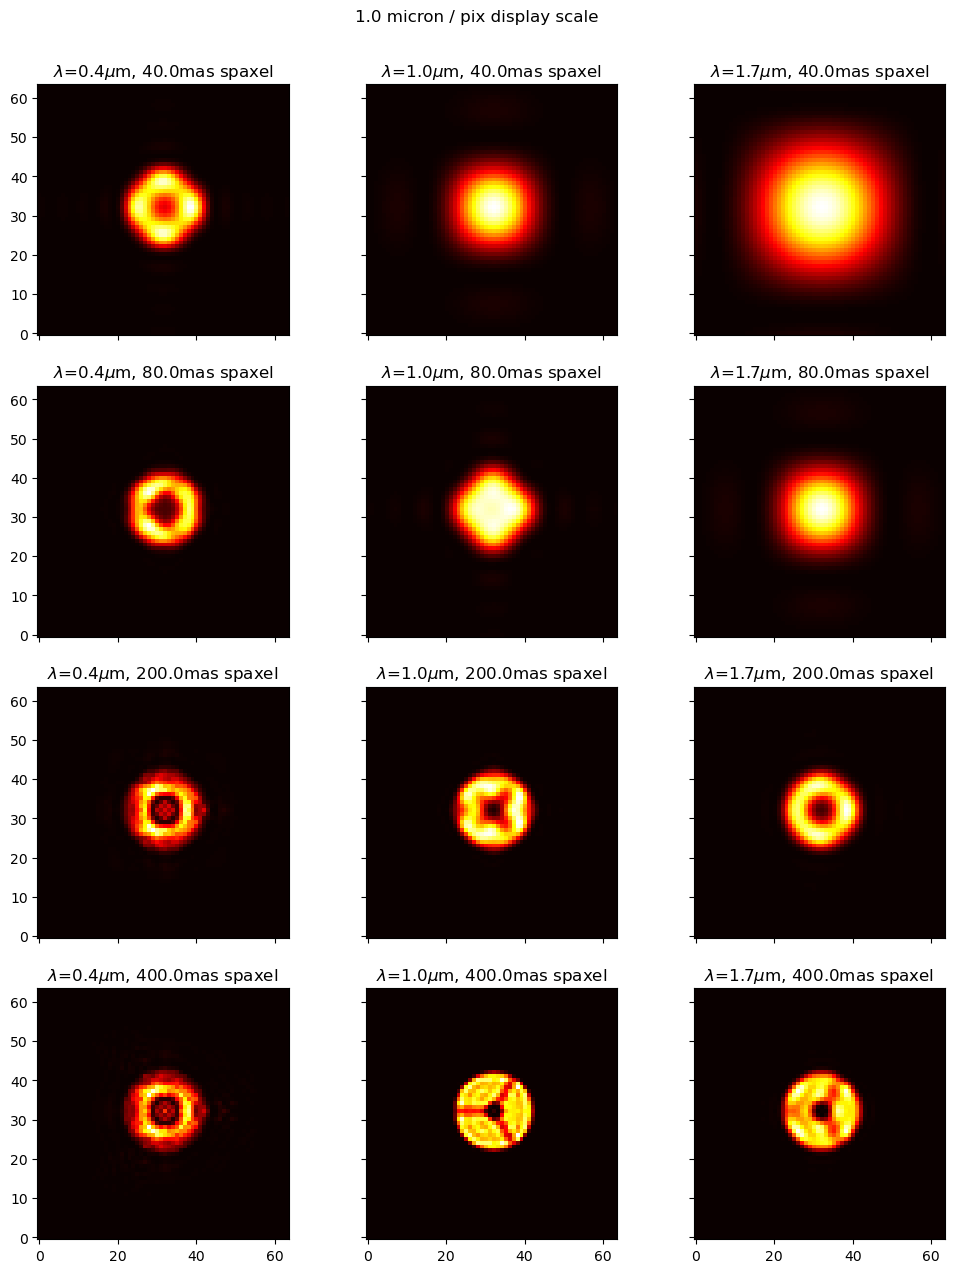

In [7]:
# Make plot
n_w = len(wavelengths)
n_s = len(scales)
fig, axis = plt.subplots(n_s, n_w, sharex=True, sharey=True)
for i in range(n_w):
    for j in range(n_s):
        axis[j,i].set_box_aspect(1)
        axis[j,i].imshow(psf_array[j][i], cmap='hot', interpolation='none', origin='lower')
        axis[j,i].set_title('$\lambda$='+str(wavelengths[i].value) + '$\mu$m, ' + str(scales[j]*fs_size*1000)+'mas spaxel')

fig.set_figwidth(12)
fig.set_figheight(15)
junk = fig.suptitle(detscale.to_string() + ' display scale', y=.93)